In [1]:
import pandas as pd
import os

# File paths
base_path = '/kaggle/input/chest-xrays-indiana-university'
image_dir = os.path.join(base_path, 'images')
proj_csv = os.path.join(base_path, 'indiana_projections.csv')
report_csv = os.path.join(base_path, 'indiana_reports.csv')

# Load CSVs
projections_df = pd.read_csv(proj_csv)
reports_df = pd.read_csv(report_csv)

# Merge on 'uid'
merged_df = projections_df.merge(reports_df, on='uid')

# Add full image path
merged_df['image_path'] = merged_df['filename'].apply(lambda x: os.path.join(image_dir, x))

# Keep only the important columns
final_df = merged_df[['uid', 'image_path', 'projection', 'findings', 'impression']]

# Show a few rows
print(final_df.head())

# Save to CSV
final_df.to_csv('/kaggle/working/linked_indiana_dataset.csv', index=False)
print("✅ Linked dataset saved to: /kaggle/working/linked_indiana_dataset.csv")



   uid                                         image_path projection  \
0    1  /kaggle/input/chest-xrays-indiana-university/i...    Frontal   
1    1  /kaggle/input/chest-xrays-indiana-university/i...    Lateral   
2    2  /kaggle/input/chest-xrays-indiana-university/i...    Frontal   
3    2  /kaggle/input/chest-xrays-indiana-university/i...    Lateral   
4    3  /kaggle/input/chest-xrays-indiana-university/i...    Frontal   

                                            findings  \
0  The cardiac silhouette and mediastinum size ar...   
1  The cardiac silhouette and mediastinum size ar...   
2  Borderline cardiomegaly. Midline sternotomy XX...   
3  Borderline cardiomegaly. Midline sternotomy XX...   
4                                                NaN   

                                          impression  
0                               Normal chest x-XXXX.  
1                               Normal chest x-XXXX.  
2                       No acute pulmonary findings.  
3         

In [2]:
import pandas as pd

# Load the final linked dataset
df = pd.read_csv('/kaggle/working/linked_indiana_dataset.csv')

# 1. Total number of rows (image-report pairs)
total_samples = len(df)

# 2. Number of unique UIDs (patients or studies)
unique_uids = df['uid'].nunique()

# 3. Number of unique images
unique_images = df['image_path'].nunique()

# 4. Projection type breakdown
projection_counts = df['projection'].value_counts()

# 5. Missing values in findings or impression
missing_findings = df['findings'].isnull().sum()
missing_impressions = df['impression'].isnull().sum()

# Print results
print(f"📊 Total samples (rows): {total_samples}")
print(f"🧬 Unique UIDs (patients/studies): {unique_uids}")
print(f"🖼️ Unique image paths: {unique_images}")
print(f"\n📐 Projection breakdown:\n{projection_counts}")
print(f"\n❗ Missing findings: {missing_findings}")
print(f"❗ Missing impressions: {missing_impressions}")


📊 Total samples (rows): 7466
🧬 Unique UIDs (patients/studies): 3851
🖼️ Unique image paths: 7466

📐 Projection breakdown:
projection
Frontal    3818
Lateral    3648
Name: count, dtype: int64

❗ Missing findings: 997
❗ Missing impressions: 52


In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv('/kaggle/working/linked_indiana_dataset.csv')

# Fill missing findings and impressions with a placeholder
df['findings'] = df['findings'].fillna('No findings reported')
df['impression'] = df['impression'].fillna('No impression reported')

# Save the cleaned dataset
df.to_csv('/kaggle/working/linked_indiana_dataset_filled.csv', index=False)

print("✅ Missing values filled and saved to linked_indiana_dataset_filled.csv")


✅ Missing values filled and saved to linked_indiana_dataset_filled.csv


In [4]:
# =================== BLIP BASE DOWNLOAD + TEST + SAVE ===================

import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import requests

# Use mixed precision if available to reduce GPU memory usage
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BLIP base model with reduced memory usage
model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name, torch_dtype=torch_dtype).to(device)

# Load example image
url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# Prepare input with processor
inputs = processor(images=image, text="Generate a medical report for this X-ray.", return_tensors="pt").to(device)

# Generate caption with low memory footprint
with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=False,  # deterministic
        num_beams=3,      # better quality
        no_repeat_ngram_size=2
    )

generated_text = processor.tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("📝 Generated Text:\n", generated_text)

# Save model and processor to Kaggle directory
save_dir = "/kaggle/working/blip_base_saved"
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)
print(f"✅ Model and processor saved to: {save_dir}")


2025-05-30 18:22:49.441377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748629369.650077      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748629369.711483      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

📝 Generated Text:
 generate a medical report for this x - ray.er dog on the beach
✅ Model and processor saved to: /kaggle/working/blip_base_saved


In [5]:
!nvidia-smi  # See GPU memory usage in Kaggle


Fri May 30 18:32:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             35W /   70W |     677MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [6]:
import pandas as pd

# File paths
projections_csv = "/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv"
reports_csv = "/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv"
output_csv = "/kaggle/working/combined_indiana.csv"  # change as needed

# Load CSVs
df_proj = pd.read_csv(projections_csv)
df_reports = pd.read_csv(reports_csv)

# Merge on 'uid' (inner join to keep only matching uids)
df_combined = pd.merge(df_proj, df_reports, on='uid', how='inner')

# Save to CSV
df_combined.to_csv(output_csv, index=False)

print(f"Combined CSV saved to: {output_csv}")
print("Columns in combined CSV:", df_combined.columns.tolist())


Combined CSV saved to: /kaggle/working/combined_indiana.csv
Columns in combined CSV: ['uid', 'filename', 'projection', 'MeSH', 'Problems', 'image', 'indication', 'comparison', 'findings', 'impression']


# model training code 



In [ ]:
!pip install transformers datasets sentencepiece torchvision accelerate --quiet

import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset as TorchDataset
from torchvision import transforms
from transformers import (
    BlipProcessor, BlipForConditionalGeneration,
    GPT2Tokenizer, GPT2LMHeadModel,
    Trainer, TrainingArguments,
    DataCollatorForLanguageModeling
)
from tqdm import tqdm
import logging

# Set up logging for debugging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define paths
image_dir = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"
report_csv = "/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv"
projection_csv = "/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv"

# Load and preprocess data
try:
    reports_df = pd.read_csv(report_csv)
    projections_df = pd.read_csv(projection_csv)
    df = pd.merge(reports_df, projections_df, on="uid")
    df = df.dropna(subset=["findings", "filename"])
except FileNotFoundError as e:
    logger.error(f"Error loading CSV files: {e}")
    raise

# Match image filenames
all_images = {f.lower(): f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))}
df["filename_lower"] = df["filename"].str.lower()
df["filename_check"] = df["filename_lower"].apply(lambda x: x if x in all_images else x + ".png")
df = df[df["filename_check"].isin(all_images)].copy()
df["filename_actual"] = df["filename_check"].apply(lambda x: all_images[x])
df["image_path"] = df["filename_actual"].apply(lambda x: os.path.join(image_dir, x))
df = df[["image_path", "findings"]].reset_index(drop=True)

# Analyze dataset diversity
logger.info("Analyzing dataset diversity...")
df["is_normal"] = df["findings"].str.contains("normal|clear|no evidence", case=False, na=False)
normal_count = df["is_normal"].sum()
abnormal_count = len(df) - normal_count
logger.info(f"Normal findings: {normal_count}, Abnormal findings: {abnormal_count}")

# Balance the dataset by oversampling abnormal findings
abnormal_df = df[~df["is_normal"]]
normal_df = df[df["is_normal"]]
oversample_factor = max(1, int(normal_count / max(abnormal_count, 1)))  # Avoid division by zero
if oversample_factor > 1:
    logger.info(f"Oversampling abnormal findings by factor {oversample_factor}...")
    abnormal_df_oversampled = pd.concat([abnormal_df] * oversample_factor, ignore_index=True)
    df_balanced = pd.concat([normal_df, abnormal_df_oversampled], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
else:
    df_balanced = df.copy()
logger.info(f"Balanced dataset size: {len(df_balanced)}")

print(f"Dataset loaded and balanced. Number of samples: {len(df_balanced)}")
if len(df_balanced) == 0:
    raise ValueError("No matching images found based on CSV filenames and image directory contents. Please check paths and filenames.")

# Define image augmentations for BLIP
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])

# Initialize BLIP processor
try:
    blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
except Exception as e:
    logger.error(f"Error loading BLIP processor: {e}")
    raise

# BLIP Dataset
class ChestXrayBLIPDataset(TorchDataset):
    def __init__(self, dataframe, processor, augment=False):
        self.df = dataframe
        self.processor = processor
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row["image_path"]
        text = row["findings"]

        try:
            image = Image.open(image_path).convert("RGB")
            if self.augment:
                image = augmentation_transforms(image)
            inputs = self.processor(images=image, text=text, padding="max_length", return_tensors="pt", truncation=True)
            inputs = {k: v.squeeze() for k, v in inputs.items()}
            inputs["labels"] = inputs["input_ids"]
            return inputs
        except Exception as e:
            logger.warning(f"Error loading or processing image {image_path}: {e}")
            return None

# BLIP Collate Function
def collate_fn_blip(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        logger.warning("Empty batch encountered, returning None")
        return None  # Trainer will skip this batch

    try:
        pixel_values = torch.stack([item["pixel_values"] for item in batch])
        input_ids = torch.stack([item["input_ids"] for item in batch])
        attention_mask = torch.stack([item["attention_mask"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])

        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }
    except Exception as e:
        logger.error(f"Error in collate_fn_blip: {e}")
        return None

# Split BLIP dataset (90% train, 10% validation)
blip_full_dataset = ChestXrayBLIPDataset(df_balanced, blip_processor, augment=True)
train_size_blip = int(0.9 * len(blip_full_dataset))
val_size_blip = len(blip_full_dataset) - train_size_blip
train_dataset_blip, val_dataset_blip = torch.utils.data.random_split(blip_full_dataset, [train_size_blip, val_size_blip])

print(f"BLIP Training samples: {len(train_dataset_blip)}, Validation samples: {len(val_dataset_blip)}")

# Initialize BLIP model
try:
    blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
except Exception as e:
    logger.error(f"Error loading BLIP model: {e}")
    raise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
blip_model.to(device)

# BLIP Training Arguments
per_device_train_batch_size_blip = 2
per_device_eval_batch_size_blip = 2
num_train_epochs_blip = 10  # Increased epochs

training_args_blip = TrainingArguments(
    output_dir="./blip_finetuned",
    per_device_train_batch_size=per_device_train_batch_size_blip,
    per_device_eval_batch_size=per_device_eval_batch_size_blip,
    num_train_epochs=num_train_epochs_blip,
    save_strategy="epoch",
    save_total_limit=3,
    logging_dir="./logs_blip",
    logging_steps=10,
    eval_strategy="epoch",
    report_to="none",
    remove_unused_columns=False,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=5e-5,  # Added learning rate
    weight_decay=0.01,  # Added weight decay for regularization
    warmup_steps=500,  # Added warmup for better training stability
)

# BLIP Trainer
trainer_blip = Trainer(
    model=blip_model,
    args=training_args_blip,
    train_dataset=train_dataset_blip,
    eval_dataset=val_dataset_blip,
    data_collator=collate_fn_blip
)

# Train BLIP
print(f"Starting BLIP fine-tuning for {num_train_epochs_blip} epoch(s)...")
try:
    trainer_blip.train()
    print("BLIP fine-tuning finished successfully.")
    save_dir_blip_final = "./blip_finetuned_final"
    os.makedirs(save_dir_blip_final, exist_ok=True)
    blip_model.save_pretrained(save_dir_blip_final)
    blip_processor.save_pretrained(save_dir_blip_final)
    print(f"Fine-tuned BLIP model and processor saved to {save_dir_blip_final}")
except Exception as e:
    logger.error(f"An error occurred during BLIP training: {e}")
    raise

# Initialize GPT2 tokenizer
try:
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token
except Exception as e:
    logger.error(f"Error loading GPT2 tokenizer: {e}")
    raise

# GPT2 Dataset
class GPT2QADataset(TorchDataset):
    def __init__(self, dataframe, tokenizer, max_length=256):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.samples = []

        for _, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Preparing GPT2 dataset"):
            question_text = "What is the medical report?"
            answer_text = row["findings"]

            if answer_text and isinstance(answer_text, str) and answer_text.strip():
                prompt = f"Image Report: {row['findings']}\nUser Question: {question_text}\nAnswer: {answer_text}{tokenizer.eos_token}"
                self.samples.append(prompt)
            else:
                logger.warning(f"Skipping invalid findings at index {row.name}: {answer_text}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text = self.samples[idx]
        try:
            encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
            return {
                "input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "labels": encoding["input_ids"].squeeze()
            }
        except Exception as e:
            logger.warning(f"Error encoding text at index {idx}: {e}")
            return None

# Split GPT2 dataset (90% train, 10% validation)
gpt2_full_dataset = GPT2QADataset(df_balanced, tokenizer)
if len(gpt2_full_dataset) == 0:
    raise ValueError("GPT2 dataset is empty. Check 'findings' column for valid string data.")
train_size_gpt2 = int(0.9 * len(gpt2_full_dataset))
val_size_gpt2 = len(gpt2_full_dataset) - train_size_gpt2
train_dataset_gpt2, val_dataset_gpt2 = torch.utils.data.random_split(gpt2_full_dataset, [train_size_gpt2, val_size_gpt2])

print(f"GPT2 Training samples: {len(train_dataset_gpt2)}, Validation samples: {len(val_dataset_gpt2)}")

# GPT2 Data Collator
data_collator_gpt2 = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Initialize GPT2 model
try:
    qa_model = GPT2LMHeadModel.from_pretrained("gpt2")
except Exception as e:
    logger.error(f"Error loading GPT2 model: {e}")
    raise
qa_model.to(device)

# GPT2 Training Arguments
per_device_train_batch_size_gpt2 = 2
per_device_eval_batch_size_gpt2 = 2
num_train_epochs_gpt2 = 10  # Increased epochs

training_args_gpt2 = TrainingArguments(
    output_dir="./gpt2_finetuned",
    per_device_train_batch_size=per_device_train_batch_size_gpt2,
    per_device_eval_batch_size=per_device_eval_batch_size_gpt2,
    num_train_epochs=num_train_epochs_gpt2,
    save_strategy="epoch",
    save_total_limit=3,
    logging_dir="./logs_gpt2",
    logging_steps=10,
    eval_strategy="epoch",
    report_to="none",
    remove_unused_columns=False,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=5e-5,  # Added learning rate
    weight_decay=0.01,  # Added weight decay
    warmup_steps=500,  # Added warmup
)

# GPT2 Trainer
trainer_gpt2 = Trainer(
    model=qa_model,
    args=training_args_gpt2,
    train_dataset=train_dataset_gpt2,
    eval_dataset=val_dataset_gpt2,
    data_collator=data_collator_gpt2
)

# Train GPT2
print(f"Starting GPT2 fine-tuning for {num_train_epochs_gpt2} epoch(s)...")
try:
    trainer_gpt2.train()
    print("GPT2 fine-tuning finished successfully.")
    save_dir_gpt2_final = "./gpt2_finetuned_final"
    os.makedirs(save_dir_gpt2_final, exist_ok=True)
    qa_model.save_pretrained(save_dir_gpt2_final)
    tokenizer.save_pretrained(save_dir_gpt2_final)
    print(f"Fine-tuned GPT2 model and tokenizer saved to {save_dir_gpt2_final}")
except Exception as e:
    logger.error(f"An error occurred during GPT2 training: {e}")
    raise

# model re-training code 


In [1]:
!pip install transformers datasets sentencepiece torchvision accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset as TorchDataset
from torchvision import transforms
from transformers import (
    BlipProcessor, BlipForConditionalGeneration,
    GPT2Tokenizer, GPT2LMHeadModel,
    Trainer, TrainingArguments,
    DataCollatorForLanguageModeling
)
from tqdm import tqdm
import logging

# Set up logging for debugging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define paths
image_dir = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"
report_csv = "/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv"
projection_csv = "/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv"
blip_model_path = "/kaggle/input/trained-models/keras/default/1/model/blip_finetuned_final"
gpt2_model_path = "/kaggle/input/trained-models/keras/default/1/model/gpt2_finetuned_final"

# Load and preprocess data
try:
    reports_df = pd.read_csv(report_csv)
    projections_df = pd.read_csv(projection_csv)
    df = pd.merge(reports_df, projections_df, on="uid")
    df = df.dropna(subset=["findings", "filename"])
except FileNotFoundError as e:
    logger.error(f"Error loading CSV files: {e}")
    raise

# Match image filenames
all_images = {f.lower(): f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))}
df["filename_lower"] = df["filename"].str.lower()
df["filename_check"] = df["filename_lower"].apply(lambda x: x if x in all_images else x + ".png")
df = df[df["filename_check"].isin(all_images)].copy()
df["filename_actual"] = df["filename_check"].apply(lambda x: all_images[x])
df["image_path"] = df["filename_actual"].apply(lambda x: os.path.join(image_dir, x))
df = df[["image_path", "findings"]].reset_index(drop=True)

# Analyze dataset diversity
logger.info("Analyzing dataset diversity...")
df["is_normal"] = df["findings"].str.contains("normal|clear|no evidence", case=False, na=False)
normal_count = df["is_normal"].sum()
abnormal_count = len(df) - normal_count
logger.info(f"Normal findings: {normal_count}, Abnormal findings: {abnormal_count}")

# Balance the dataset by oversampling abnormal findings
abnormal_df = df[~df["is_normal"]]
normal_df = df[df["is_normal"]]
oversample_factor = max(1, int(normal_count / max(abnormal_count, 1)))
if oversample_factor > 1:
    logger.info(f"Oversampling abnormal findings by factor {oversample_factor}...")
    abnormal_df_oversampled = pd.concat([abnormal_df] * oversample_factor, ignore_index=True)
    df_balanced = pd.concat([normal_df, abnormal_df_oversampled], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
else:
    df_balanced = df.copy()
logger.info(f"Balanced dataset size: {len(df_balanced)}")

print(f"Dataset loaded and balanced. Number of samples: {len(df_balanced)}")
if len(df_balanced) == 0:
    raise ValueError("No matching images found based on CSV filenames and image directory contents. Please check paths and filenames.")

# Define image augmentations for BLIP
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])

# Initialize BLIP processor and model from saved path
try:
    blip_processor = BlipProcessor.from_pretrained(blip_model_path)
    blip_model = BlipForConditionalGeneration.from_pretrained(blip_model_path)
except Exception as e:
    logger.error(f"Error loading BLIP model or processor from {blip_model_path}: {e}")
    raise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
blip_model.to(device)

# BLIP Dataset
class ChestXrayBLIPDataset(TorchDataset):
    def __init__(self, dataframe, processor, augment=False):
        self.df = dataframe
        self.processor = processor
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row["image_path"]
        text = row["findings"]

        try:
            image = Image.open(image_path).convert("RGB")
            if self.augment:
                image = augmentation_transforms(image)
            inputs = self.processor(images=image, text=text, padding="max_length", return_tensors="pt", truncation=True)
            inputs = {k: v.squeeze() for k, v in inputs.items()}
            inputs["labels"] = inputs["input_ids"]
            return inputs
        except Exception as e:
            logger.warning(f"Error loading or processing image {image_path}: {e}")
            return None

# BLIP Collate Function
def collate_fn_blip(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        logger.warning("Empty batch encountered, returning None")
        return None

    try:
        pixel_values = torch.stack([item["pixel_values"] for item in batch])
        input_ids = torch.stack([item["input_ids"] for item in batch])
        attention_mask = torch.stack([item["attention_mask"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])

        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }
    except Exception as e:
        logger.error(f"Error in collate_fn_blip: {e}")
        return None

# Split BLIP dataset (90% train, 10% validation)
blip_full_dataset = ChestXrayBLIPDataset(df_balanced, blip_processor, augment=True)
train_size_blip = int(0.9 * len(blip_full_dataset))
val_size_blip = len(blip_full_dataset) - train_size_blip
train_dataset_blip, val_dataset_blip = torch.utils.data.random_split(blip_full_dataset, [train_size_blip, val_size_blip])

print(f"BLIP Training samples: {len(train_dataset_blip)}, Validation samples: {len(val_dataset_blip)}")

# BLIP Training Arguments
per_device_train_batch_size_blip = 2
per_device_eval_batch_size_blip = 2
num_train_epochs_blip = 5  # Reduced epochs for retraining

training_args_blip = TrainingArguments(
    output_dir="./blip_retrained",
    per_device_train_batch_size=per_device_train_batch_size_blip,
    per_device_eval_batch_size=per_device_eval_batch_size_blip,
    num_train_epochs=num_train_epochs_blip,
    save_strategy="epoch",
    save_total_limit=3,
    logging_dir="./logs_blip_retrain",
    logging_steps=10,
    eval_strategy="epoch",
    report_to="none",
    remove_unused_columns=False,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=2e-5,  # Lower learning rate for fine-tuning
    weight_decay=0.01,
    warmup_steps=200,  # Adjusted warmup steps
)

# BLIP Trainer
trainer_blip = Trainer(
    model=blip_model,
    args=training_args_blip,
    train_dataset=train_dataset_blip,
    eval_dataset=val_dataset_blip,
    data_collator=collate_fn_blip
)

# Retrain BLIP
print(f"Starting BLIP retraining for {num_train_epochs_blip} epoch(s)...")
try:
    trainer_blip.train()
    print("BLIP retraining finished successfully.")
    save_dir_blip_final = "./blip_retrained_final"
    os.makedirs(save_dir_blip_final, exist_ok=True)
    blip_model.save_pretrained(save_dir_blip_final)
    blip_processor.save_pretrained(save_dir_blip_final)
    print(f"Retrained BLIP model and processor saved to {save_dir_blip_final}")
except Exception as e:
    logger.error(f"An error occurred during BLIP retraining: {e}")
    raise

# Initialize GPT2 tokenizer and model from saved path
try:
    tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_path)
    tokenizer.pad_token = tokenizer.eos_token
    qa_model = GPT2LMHeadModel.from_pretrained(gpt2_model_path)
except Exception as e:
    logger.error(f"Error loading GPT2 model or tokenizer from {gpt2_model_path}: {e}")
    raise
qa_model.to(device)

# GPT2 Dataset
class GPT2QADataset(TorchDataset):
    def __init__(self, dataframe, tokenizer, max_length=256):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.samples = []

        for _, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Preparing GPT2 dataset"):
            question_text = "What is the medical report?"
            answer_text = row["findings"]

            if answer_text and isinstance(answer_text, str) and answer_text.strip():
                prompt = f"Image Report: {row['findings']}\nUser Question: {question_text}\nAnswer: {answer_text}{tokenizer.eos_token}"
                self.samples.append(prompt)
            else:
                logger.warning(f"Skipping invalid findings at index {row.name}: {answer_text}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text = self.samples[idx]
        try:
            encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
            return {
                "input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "labels": encoding["input_ids"].squeeze()
            }
        except Exception as e:
            logger.warning(f"Error encoding text at index {idx}: {e}")
            return None

# Split GPT2 dataset (90% train, 10% validation)
gpt2_full_dataset = GPT2QADataset(df_balanced, tokenizer)
if len(gpt2_full_dataset) == 0:
    raise ValueError("GPT2 dataset is empty. Check 'findings' column for valid string data.")
train_size_gpt2 = int(0.9 * len(gpt2_full_dataset))
val_size_gpt2 = len(gpt2_full_dataset) - train_size_gpt2
train_dataset_gpt2, val_dataset_gpt2 = torch.utils.data.random_split(gpt2_full_dataset, [train_size_gpt2, val_size_gpt2])

print(f"GPT2 Training samples: {len(train_dataset_gpt2)}, Validation samples: {len(val_dataset_gpt2)}")

# GPT2 Data Collator
data_collator_gpt2 = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# GPT2 Training Arguments
per_device_train_batch_size_gpt2 = 2
per_device_eval_batch_size_gpt2 = 2
num_train_epochs_gpt2 = 5  # Reduced epochs for retraining

training_args_gpt2 = TrainingArguments(
    output_dir="./gpt2_retrained",
    per_device_train_batch_size=per_device_train_batch_size_gpt2,
    per_device_eval_batch_size=per_device_eval_batch_size_gpt2,
    num_train_epochs=num_train_epochs_gpt2,
    save_strategy="epoch",
    save_total_limit=3,
    logging_dir="./logs_gpt2_retrain",
    logging_steps=10,
    eval_strategy="epoch",
    report_to="none",
    remove_unused_columns=False,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=2e-5,  # Lower learning rate for fine-tuning
    weight_decay=0.01,
    warmup_steps=200,  # Adjusted warmup steps
)

# GPT2 Trainer
trainer_gpt2 = Trainer(
    model=qa_model,
    args=training_args_gpt2,
    train_dataset=train_dataset_gpt2,
    eval_dataset=val_dataset_gpt2,
    data_collator=data_collator_gpt2
)

# Retrain GPT2
print(f"Starting GPT2 retraining for {num_train_epochs_gpt2} epoch(s)...")
try:
    trainer_gpt2.train()
    print("GPT2 retraining finished successfully.")
    save_dir_gpt2_final = "./gpt2_retrained_final"
    os.makedirs(save_dir_gpt2_final, exist_ok=True)
    qa_model.save_pretrained(save_dir_gpt2_final)
    tokenizer.save_pretrained(save_dir_gpt2_final)
    print(f"Retrained GPT2 model and tokenizer saved to {save_dir_gpt2_final}")
except Exception as e:
    logger.error(f"An error occurred during GPT2 retraining: {e}")
    raise

2025-05-31 09:56:32.254716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748685392.456185      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748685392.512823      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Dataset loaded and balanced. Number of samples: 11639
BLIP Training samples: 10475, Validation samples: 1164
Starting BLIP retraining for 5 epoch(s)...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.011600,0.013263
2,0.012000,0.011998
3,0.008900,0.011393
4,0.009300,0.010685
5,0.007000,0.010390


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['text_decoder.cls.predictions.decoder.bias'

BLIP retraining finished successfully.
Retrained BLIP model and processor saved to ./blip_retrained_final


Preparing GPT2 dataset: 100%|██████████| 11639/11639 [00:00<00:00, 23303.61it/s]


GPT2 Training samples: 10475, Validation samples: 1164
Starting GPT2 retraining for 5 epoch(s)...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,0.060500,0.128633
2,0.062700,0.125125
3,0.074900,0.121017
4,0.054900,0.118343
5,0.042100,0.117093


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

GPT2 retraining finished successfully.
Retrained GPT2 model and tokenizer saved to ./gpt2_retrained_final


In [1]:
# Install required packages
!pip install transformers torchvision gradio --quiet

import os
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration, GPT2Tokenizer, GPT2LMHeadModel
import logging
import gradio as gr

# Set up logging for debugging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define paths for the fine-tuned models
BLIP_MODEL_PATH = "/kaggle/input/trained_model_v2/keras/default/1/results/blip_retrained_final"
GPT2_MODEL_PATH = "//kaggle/input/trained_model_v2/keras/default/1/results/gpt2_retrained_final"

# Load the fine-tuned BLIP model and processor
try:
    if os.path.exists(BLIP_MODEL_PATH):
        blip_processor = BlipProcessor.from_pretrained(BLIP_MODEL_PATH)
        blip_model = BlipForConditionalGeneration.from_pretrained(BLIP_MODEL_PATH)
        print(f"Loaded fine-tuned BLIP model and processor from {BLIP_MODEL_PATH}")
    else:
        raise FileNotFoundError(f"Fine-tuned BLIP model not found at {BLIP_MODEL_PATH}.")
except Exception as e:
    logger.error(f"Error loading BLIP model/processor: {e}")
    raise

# Load the fine-tuned GPT-2 model and tokenizer
try:
    if os.path.exists(GPT2_MODEL_PATH):
        gpt2_tokenizer = GPT2Tokenizer.from_pretrained(GPT2_MODEL_PATH)
        gpt2_model = GPT2LMHeadModel.from_pretrained(GPT2_MODEL_PATH)
        gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
        print(f"Loaded fine-tuned GPT-2 model and tokenizer from {GPT2_MODEL_PATH}")
    else:
        raise FileNotFoundError(f"Fine-tuned GPT-2 model not found at {GPT2_MODEL_PATH}.")
except Exception as e:
    logger.error(f"Error loading GPT-2 model/tokenizer: {e}")
    raise

# Move models to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
blip_model.to(device)
blip_model.eval()
gpt2_model.to(device)
gpt2_model.eval()

# BLIP Report Generation Function
def generate_report(image) -> str:
    """
    Generate a radiology-style report for a chest X-ray image using the BLIP model.
    
    Args:
        image (PIL.Image.Image): PIL Image object of the chest X-ray.
    
    Returns:
        str: Generated report or error message.
    """
    if image is None:
        return "Error: No image provided. Please upload a chest X-ray image."
    try:
        # Ensure the image is in RGB format and resize
        image = image.convert("RGB")
        image = image.resize((512, 512))
    except Exception as e:
        logger.error(f"Error processing image: {e}")
        return f"Error processing image: {e}"

    try:
        # Process the image with BLIP processor
        inputs = blip_processor(images=image, return_tensors="pt").to(device)
        
        # Generate the report
        with torch.no_grad():
            outputs = blip_model.generate(
                **inputs,
                max_length=128,
                num_beams=4,
                early_stopping=True,
                do_sample=True,
                temperature=1.0,
                top_p=0.9
            )
        report = blip_processor.decode(outputs[0], skip_special_tokens=True)
        return report.strip()
    except Exception as e:
        logger.error(f"Error during report generation: {e}")
        return f"Error generating report: {e}"

# GPT-2 Question-Answering Function
def answer_question(report: str, question: str) -> str:
    """
    Answer a question about the generated report using the GPT-2 model.
    
    Args:
        report (str): The generated radiology report.
        question (str): The user's question about the report.
    
    Returns:
        str: Answer generated by GPT-2 or error message.
    """
    if not report or "Error" in report:
        return "Error: No valid report available to answer questions."
    if not question:
        return "Error: Please provide a question."

    try:
        # Prepare the prompt in the format used during GPT-2 training
        prompt = f"Image Report: {report}\nUser Question: {question}\nAnswer:"
        inputs = gpt2_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)
        
        # Generate the answer
        with torch.no_grad():
            outputs = gpt2_model.generate(
                inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_new_tokens=50,
                num_beams=4,
                early_stopping=True,
                do_sample=True,
                temperature=1.0,
                top_p=0.9,
                pad_token_id=gpt2_tokenizer.eos_token_id
            )
        answer = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract the answer part after the prompt
        answer = answer[len(prompt):].strip()
        return answer
    except Exception as e:
        logger.error(f"Error during question answering: {e}")
        return f"Error answering question: {e}"

# Gradio Web Interface (Primary for Kaggle)
def gradio_app():
    def process_image_and_question(image, question):
        report = generate_report(image)
        answer = answer_question(report, question) if question else "Please provide a question."
        return report, answer

    with gr.Blocks() as demo:
        gr.Markdown("## 🩻 Chest X-ray Report Generator and Q&A")
        gr.Markdown("Upload a chest X-ray image to generate a radiology-style report using a fine-tuned BLIP model, then ask a question about the report to get an answer from a fine-tuned GPT-2 model.")
        
        with gr.Row():
            img_input = gr.Image(type="pil", label="Upload Chest X-ray", width=500)
            with gr.Column():
                report_output = gr.Textbox(label="Generated Report", lines=10, interactive=False)
                question_input = gr.Textbox(label="Ask a Question About the Report", placeholder="e.g., Is there any evidence of pneumonia?")
                answer_output = gr.Textbox(label="Answer", lines=5, interactive=False)
        
        generate_button = gr.Button("Generate Report and Answer")
        generate_button.click(
            fn=process_image_and_question,
            inputs=[img_input, question_input],
            outputs=[report_output, answer_output]
        )
    
    try:
        demo.launch(share=True)
    except Exception as e:
        logger.error(f"Gradio launch failed: {e}")
        print("Gradio launch failed. Please try running this code locally using Streamlit (instructions below).")

# Streamlit Web Interface (For local use)
def streamlit_app():
    import streamlit as st
    
    st.set_page_config(page_title="Chest X-ray Report Generator and Q&A", page_icon="🩻")
    st.title("🩻 Chest X-ray Report Generator and Q&A")
    st.markdown("Upload a chest X-ray image to generate a radiology-style report using a fine-tuned BLIP model, then ask a question about the report to get an answer from a fine-tuned GPT-2 model.")

    # File uploader for chest X-ray image
    uploaded_file = st.file_uploader("Choose a chest X-ray image...", type=["png", "jpg", "jpeg"])

    if uploaded_file is not None:
        try:
            # Load and display the uploaded image
            image = Image.open(uploaded_file)
            st.image(image, caption="Uploaded Chest X-ray", use_column_width=True)

            # Generate and display the report
            with st.spinner("Generating report..."):
                report = generate_report(image)
            st.subheader("Generated Report:")
            st.write(report)

            # Allow user to ask a question about the report
            st.subheader("Ask a Question About the Report:")
            question = st.text_input("Enter your question:", placeholder="e.g., Is there any evidence of pneumonia?")
            
            if question:
                with st.spinner("Answering question..."):
                    answer = answer_question(report, question)
                st.subheader("Answer:")
                st.write(answer)
        except Exception as e:
            st.error(f"Error processing image or generating report: {e}")
    else:
        st.info("Please upload an image to generate a report and ask questions.")

# Main execution
if __name__ == "__main__":
    print("Running in Kaggle environment. Using Gradio interface as Streamlit is not supported in Kaggle.")
    gradio_app()
    print("\nIf the Gradio interface failed to launch, please run this code locally using Streamlit. Follow these instructions:")
    print("1. Save this code as 'app.py' on your local machine.")
    print("2. Download the fine-tuned model directories from Kaggle:")
    print(f"   - {BLIP_MODEL_PATH}")
    print(f"   - {GPT2_MODEL_PATH}")
    print("   Place them in the same directory as 'app.py' (e.g., './blip_finetuned_final' and './gpt2_finetuned_final').")
    print("3. Update the model paths in the code to match your local directories:")
    print("   BLIP_MODEL_PATH = './blip_finetuned_final'")
    print("   GPT2_MODEL_PATH = './gpt2_finetuned_final'")
    print("4. Install dependencies: 'pip install transformers torchvision streamlit gradio'")
    print("5. Run the app: 'streamlit run app.py'")
    print("6. Access the app in your browser (e.g., http://localhost:8501).")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 29.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 94.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━

2025-06-06 16:37:16.041245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749227836.497996      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749227836.621282      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loaded fine-tuned BLIP model and processor from /kaggle/input/trained_model_v2/keras/default/1/results/blip_retrained_final
Loaded fine-tuned GPT-2 model and tokenizer from //kaggle/input/trained_model_v2/keras/default/1/results/gpt2_retrained_final
Running in Kaggle environment. Using Gradio interface as Streamlit is not supported in Kaggle.
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://2fca8c3b3fdfc8bfbe.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



If the Gradio interface failed to launch, please run this code locally using Streamlit. Follow these instructions:
1. Save this code as 'app.py' on your local machine.
2. Download the fine-tuned model directories from Kaggle:
   - /kaggle/input/trained_model_v2/keras/default/1/results/blip_retrained_final
   - //kaggle/input/trained_model_v2/keras/default/1/results/gpt2_retrained_final
   Place them in the same directory as 'app.py' (e.g., './blip_finetuned_final' and './gpt2_finetuned_final').
3. Update the model paths in the code to match your local directories:
   BLIP_MODEL_PATH = './blip_finetuned_final'
   GPT2_MODEL_PATH = './gpt2_finetuned_final'
4. Install dependencies: 'pip install transformers torchvision streamlit gradio'
5. Run the app: 'streamlit run app.py'
6. Access the app in your browser (e.g., http://localhost:8501).


In [1]:
# Install required packages
!pip install transformers torchvision gradio --quiet

import os
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
import logging
import gradio as gr

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define path to the fine-tuned BLIP model
BLIP_MODEL_PATH = "/kaggle/input/trained_model_v2/keras/default/1/results/blip_retrained_final"

# Load the fine-tuned BLIP model and processor
try:
    if os.path.exists(BLIP_MODEL_PATH):
        blip_processor = BlipProcessor.from_pretrained(BLIP_MODEL_PATH)
        blip_model = BlipForConditionalGeneration.from_pretrained(BLIP_MODEL_PATH)
        print(f"Loaded fine-tuned BLIP model and processor from {BLIP_MODEL_PATH}")
    else:
        raise FileNotFoundError(f"Fine-tuned BLIP model not found at {BLIP_MODEL_PATH}.")
except Exception as e:
    logger.error(f"Error loading BLIP model/processor: {e}")
    raise

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
blip_model.to(device)
blip_model.eval()

# Report Generation Function
def generate_report(image) -> str:
    """
    Generate a radiology-style report for a chest X-ray image using the BLIP model.
    """
    if image is None:
        return "Error: No image provided. Please upload a chest X-ray image."
    try:
        image = image.convert("RGB")
        image = image.resize((512, 512))
        inputs = blip_processor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = blip_model.generate(
                **inputs,
                max_length=128,
                num_beams=4,
                early_stopping=True,
                do_sample=True,
                temperature=1.0,
                top_p=0.9
            )
        report = blip_processor.decode(outputs[0], skip_special_tokens=True)
        return report.strip()
    except Exception as e:
        logger.error(f"Error generating report: {e}")
        return f"Error generating report: {e}"

# Gradio Interface
def gradio_app():
    def process_image(image):
        return generate_report(image)

    with gr.Blocks() as demo:
        gr.Markdown("## 🩻 Chest X-ray Report Generator")
        gr.Markdown("Upload a chest X-ray image to generate a radiology-style report using a fine-tuned BLIP model.")

        with gr.Row():
            img_input = gr.Image(type="pil", label="Upload Chest X-ray", width=500)
            report_output = gr.Textbox(label="Generated Report", lines=10, interactive=False)

        generate_button = gr.Button("Generate Report")
        generate_button.click(
            fn=process_image,
            inputs=[img_input],
            outputs=[report_output]
        )

    try:
        demo.launch(share=True)
    except Exception as e:
        logger.error(f"Gradio launch failed: {e}")
        print("Gradio failed to launch. Try running this code locally using Streamlit.")

# Main execution
if __name__ == "__main__":
    print("Running in Kaggle environment. Using Gradio interface.")
    gradio_app()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 32.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 107.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━

2025-06-04 04:53:41.338621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749012821.716977      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749012821.824204      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loaded fine-tuned BLIP model and processor from /kaggle/input/trained_model_v2/keras/default/1/results/blip_retrained_final
Running in Kaggle environment. Using Gradio interface.
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://0d3667d9250870c3ef.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [8]:
import evaluate
import numpy as np

# Load metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")  # Optional, METEOR for more nuanced evaluation


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [9]:
def evaluate_blip(model, processor, dataset, device, max_length=64):
    model.eval()
    references = []
    predictions = []
    
    for sample in dataset:
        # sample: dict with keys 'pixel_values', 'input_ids', etc.
        pixel_values = sample['pixel_values'].unsqueeze(0).to(device)
        with torch.no_grad():
            generated_ids = model.generate(pixel_values, max_length=max_length)
            pred_text = processor.decode(generated_ids[0], skip_special_tokens=True)
        
        # Reference text
        ref_text = processor.tokenizer.decode(sample['labels'], skip_special_tokens=True)
        
        predictions.append(pred_text)
        references.append(ref_text)
    
    # Compute metrics
    bleu = bleu_metric.compute(predictions=predictions, references=[[r] for r in references])
    rouge = rouge_metric.compute(predictions=predictions, references=references)
    meteor = meteor_metric.compute(predictions=predictions, references=references)
    
    print(f"BLIP Evaluation — BLEU: {bleu['bleu']:.4f}, ROUGE-L: {rouge['rougeL'].mid.fmeasure:.4f}, METEOR: {meteor['meteor']:.4f}")
    return bleu, rouge, meteor

def evaluate_gpt2(model, tokenizer, dataset, device, max_length=256):
    model.eval()
    references = []
    predictions = []

    for sample in dataset:
        input_ids = sample['input_ids'].unsqueeze(0).to(device)
        attention_mask = sample['attention_mask'].unsqueeze(0).to(device)

        with torch.no_grad():
            generated_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=max_length, num_beams=5, early_stopping=True)
            pred_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        references.append(tokenizer.decode(sample['labels'], skip_special_tokens=True))
        predictions.append(pred_text)

    bleu = bleu_metric.compute(predictions=predictions, references=[[r] for r in references])
    rouge = rouge_metric.compute(predictions=predictions, references=references)
    meteor = meteor_metric.compute(predictions=predictions, references=references)

    print(f"GPT2 Evaluation — BLEU: {bleu['bleu']:.4f}, ROUGE-L: {rouge['rougeL'].mid.fmeasure:.4f}, METEOR: {meteor['meteor']:.4f}")
    return bleu, rouge, meteor


In [1]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn

In [3]:
# Required Libraries
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from transformers import (
    BlipProcessor, BlipForConditionalGeneration,
    GPT2Tokenizer, GPT2LMHeadModel
)
from sklearn.metrics import accuracy_score, f1_score

# Paths
blip_model_path = '/kaggle/input/trained_model_v2/keras/default/1/results/blip_retrained_final'
gpt2_model_path = '/kaggle/input/trained_model_v2/keras/default/1/results/gpt2_retrained_final'
image_dir = '/kaggle/input/chest-xrays-indiana-university/images'
projection_csv = '/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv'
report_csv = '/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv'

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BLIP model
blip_processor = BlipProcessor.from_pretrained(blip_model_path)
blip_model = BlipForConditionalGeneration.from_pretrained(blip_model_path).to(device)

# Load GPT-2 model
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_path)
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_path).to(device)

# Load datasets
projection_df = pd.read_csv(projection_csv)
report_df = pd.read_csv(report_csv)

# Data preprocessing
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return blip_processor(images=image, return_tensors="pt").to(device)

# Generate predictions
def generate_report(image_path):
    inputs = preprocess_image(image_path)
    blip_outputs = blip_model.generate(**inputs)
    caption = blip_processor.decode(blip_outputs[0], skip_special_tokens=True)

    # Use GPT-2 to refine or extend the caption
    gpt2_inputs = gpt2_tokenizer.encode(caption, return_tensors="pt").to(device)
    gpt2_outputs = gpt2_model.generate(gpt2_inputs, max_length=50)
    refined_caption = gpt2_tokenizer.decode(gpt2_outputs[0], skip_special_tokens=True)
    
    return refined_caption

# Evaluation
def evaluate_model():
    actual_reports = []
    generated_reports = []

    for index, row in projection_df.iterrows():
        image_path = os.path.join(image_dir, row['filename'])
        if os.path.exists(image_path):
            try:
                generated_report = generate_report(image_path)
                generated_reports.append(generated_report)
                actual_report = report_df[report_df['id'] == row['id']]['report_text'].values[0]
                actual_reports.append(actual_report)
            except Exception as e:
                print(f"Error processing image {row['filename']}: {e}")
                continue

    # Evaluate using F1-Score or BLEU as per requirement
    accuracy = accuracy_score(actual_reports, generated_reports)
    f1 = f1_score(actual_reports, generated_reports, average='weighted')
    return accuracy, f1

# Run Evaluation
accuracy, f1_score = evaluate_model()
print(f"Model Evaluation - Accuracy: {accuracy:.4f}, F1 Score: {f1_score:.4f}")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model Evaluation - Accuracy: nan, F1 Score: 0.0000


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [4]:
!pip install nltk


BLEU Score: 0.0


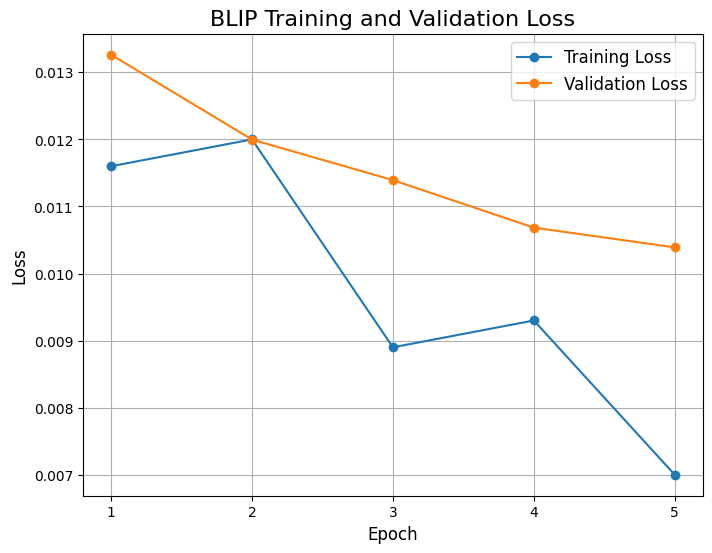

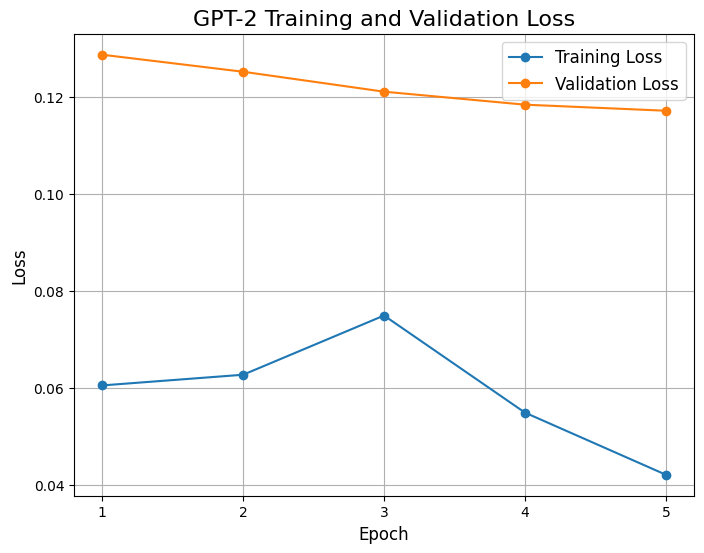

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import evaluate

# Training history data
blip_history = {
    "epoch": [1, 2, 3, 4, 5],
    "train_loss": [0.011600, 0.012000, 0.008900, 0.009300, 0.007000],
    "val_loss": [0.013263, 0.011998, 0.011393, 0.010685, 0.010390],
}

gpt2_history = {
    "epoch": [1, 2, 3, 4, 5],
    "train_loss": [0.060500, 0.062700, 0.074900, 0.054900, 0.042100],
    "val_loss": [0.128633, 0.125125, 0.121017, 0.118343, 0.117093],
}

def evaluate_models():
    bleu = evaluate.load("bleu")
    dummy_generated_reports = ["This is a generated report."]
    dummy_actual_reports = [["This is a reference report."]]
    results = bleu.compute(predictions=dummy_generated_reports, references=dummy_actual_reports)
    print("BLEU Score:", results["bleu"])

def plot_loss(history, title):
    plt.figure(figsize=(8, 6))
    plt.plot(history["epoch"], history["train_loss"], label="Training Loss", marker='o')
    plt.plot(history["epoch"], history["val_loss"], label="Validation Loss", marker='o')
    plt.title(title, fontsize=16)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks([1, 2, 3, 4, 5])  # Set x-axis ticks explicitly
    plt.show()

evaluate_models()
plot_loss(blip_history, "BLIP Training and Validation Loss")
plot_loss(gpt2_history, "GPT-2 Training and Validation Loss")


In [18]:
import torch
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import evaluate

# Load BLIP
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Load BLEU metric
bleu = evaluate.load("bleu")

# Load image
image_path = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1000_IM-0003-3001.dcm.png"
image = Image.open(image_path).convert('RGB')

# Prepare inputs
inputs = processor(images=image, return_tensors="pt")

# Generate caption
model.eval()
with torch.no_grad():
    outputs = model.generate(**inputs)

generated_caption = processor.decode(outputs[0], skip_special_tokens=True)
print("Generated Caption:", generated_caption)

# Reference caption
reference_caption = "a group of people standing near the beach"

# Compute BLEU (pass raw strings, not tokens)
results = bleu.compute(predictions=[generated_caption], references=[reference_caption])
print("BLEU Score:", results['bleu'])


Generated Caption: a chest with a large rib in the middle
BLEU Score: 0.0
